# Chapter 9. Root Finding and Nonlinear Sets of Equations

1. [Bisection](#Bracketing-and-Bisection)
2. [Secant && False Position](#Secant-Method,-False-Position-Method)
3. [Ridders' Method](#Ridders'-Method)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline
plt.ioff()


When then solution or solutions of equation $f(x)=0$ are desired, namely to find the root or roots of a function. In vector notation, we want to find one or more N-dimesional solution vectors $\textbf{x}$ such that $\textbf{f(x)}=\textbf{0}$.

In [2]:
x = np.linspace(-5, 5, 500)
x_axis = np.zeros(x.shape)


In [3]:
def plot_f(f, show=True):
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 1, 1))
    ax.plot(x, f(x))
    ax.plot(x, x_axis)
    if show:
        plt.show(fig)
        plt.close()
    return ax, fig


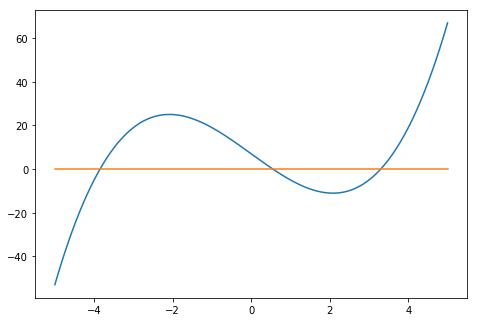

(<matplotlib.axes._axes.Axes at 0x2c298917e10>,
 <matplotlib.figure.Figure at 0x2c298917710>)

In [4]:
poly_f = lambda x: x ** 3 - 13 * x + 7
plot_f(poly_f)


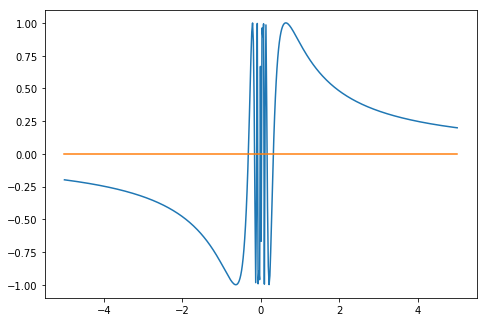

(<matplotlib.axes._axes.Axes at 0x2c298ab3358>,
 <matplotlib.figure.Figure at 0x2c298ac5320>)

In [5]:
sin_inv_f = lambda x: np.sin(1 / x)
plot_f(sin_inv_f)


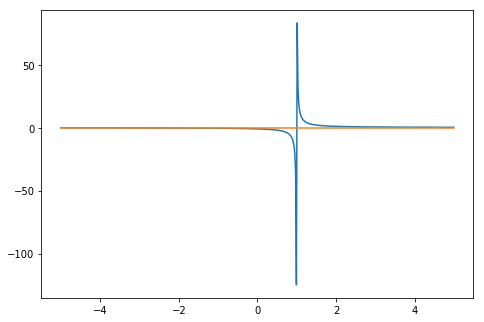

(<matplotlib.axes._axes.Axes at 0x2c298c0b908>,
 <matplotlib.figure.Figure at 0x2c298bdbc88>)

In [6]:
inv_f = lambda x: 1 / (x - 1)
plot_f(inv_f)


## Bracketing and Bisection

If $f(a)$ and $f(b)$ have opposite signs, then at least one root must lie in that interval (the intermediate value theorem). Evaluate the function at the interval's midpoint and examine its sign. Use the midpoint to replace whichever limit has the same sign. After each iteration the bounds containing the root decrease by a factor of two. If after $n$ iterations the root is known to be within an interval of size 

$$\epsilon_{n+1} = \frac{\epsilon_{n}}{2}$$

Thus, we know in advance the number of iterations requiered to achieve a given tolerance in the solution.

$$n=\log_{2}\frac{\epsilon_0}{\epsilon}$$

In [7]:
def bisection(a, b, f, tol, max_itr=None):
    hist = []
    # a and b must have opposite signs
    assert f(a) * f(b) < 0
    if max_itr is None:
        max_itr = int(np.linalg.norm(np.log2(abs(a - b) / tol))) + 2
    if (f(a) >= 0):
        pos = a
        neg = b
    else:
        neg = a
        pos = b
    for i in range(max_itr):
        hist.append([[pos, f(pos)], [neg, f(neg)]])
        if abs(f(pos) - f(neg)) > tol:
            med = (pos + neg) / 2
            if (f(med) > 0):
                pos = med
            else:
                neg = med
        else:
            return pos, hist, i
    print("exceeds the maximal iterations")
    return pos, hist, max_itr


In [8]:
def create_ani(fig, animate):
    animation = FuncAnimation(fig, animate, frames=10, interval=1000)
    return HTML(animation.to_html5_video())


In [9]:
def create_f_ani(a, b, f, appr_method, update_builder):
    r, hist, itr = appr_method(a, b, f, 10 ** -10, 50)
    print(r, itr)
    ax, fig = plot_f(f, False)
    update = update_builder(ax, hist)
    plt.close()
    return create_ani(fig, update)


In [10]:
def make_bisc_update(ax, hist):
    [a, f_a], [b, f_b] = hist[0]
    scat = ax.scatter((a, b), (f_a, f_b))
    def update(frame_number):
        scat.set_offsets(hist[frame_number])
        return (scat,)
    return update
def create_bisc_ani(a, b, f):
    return create_f_ani(a, b, f, bisection, make_bisc_update)

In [11]:
create_bisc_ani(-4, -2, poly_f)


-3.84947157464012 40


In [12]:
create_bisc_ani(2, 4, poly_f)


3.298117179005203 39


In [13]:
create_bisc_ani(-2, 1, sin_inv_f)


0.3183098861882172 39


In [14]:
create_bisc_ani(-1, 2, inv_f)


exceeds the maximal iterations
1.0000000000000009 50


The intermediate value theorem in higher dimention: 
* if $X$ and $Y$ are metric spaces, $f:X \to Y$ is a continuous map, and $E \subset X$ is a connected subset, then $f(E)$ is connected.
* A subset $E \subset \mathbb{R}$ is connected if and only if it satisfies the folliwing property, $\forall x,y \in E, x < r < y \implies r \in E$.

The perservation of connectedness under continuous maps can be though of as a generalization of the intermediate value theorem to continuous functions in general spaces.

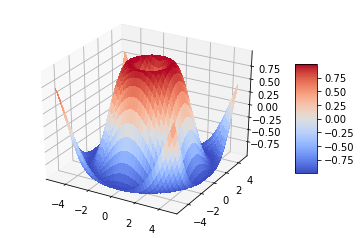

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, X)
f_2dim = lambda x: np.sin(np.sqrt(np.sum(x ** 2, axis=0)))
Z = f_2dim(np.vstack((X.reshape(1, -1), Y.reshape(1, -1)))).reshape(X.shape)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [16]:
pos, hist, max_itr = bisection(np.array([[-4], [2]]), np.array([[2], [0]]), f_2dim, 10 ** -10)
print(pos)
print(np.asscalar(f_2dim(pos)))


[[-2.71935677]
 [ 1.57311892]]
8.597446122402249e-11


## Secant Method, False Position Method

For functions that are smooth near a root, the _secant method_ generally converge faster than bisection. The function is assumed to be approximately linear in the local region of interest, and the next improvement in the root is taken as the point where the approximating line crosses the axis. Mathematically, the secant method converges more rapidly near a root of a suffieciently continuoous funciton. Its order of convergence can be shown to be the "golden ratio".

$$\lim_{x \to \infty}\left|\epsilon_{k+1}\right| \approx const * \left|\epsilon_{k}\right|^{1.618}$$

For functions that are not sufficiently continuoous, the algorithm can therefore not be guaranteed to converge.

In [17]:
def secant(a, b, f, tol, max_itr=100):
    hist = []
    x_n = a
    x_n1 = b
    for i in range(max_itr):
        dx = (x_n1 - x_n) / (f(x_n1) - f(x_n)) * f(x_n1)
        x_n2 = x_n1 - dx
        hist.append([[x_n, f(x_n)], [x_n1, f(x_n1)], [x_n2, f(x_n2)]])
        x_n = x_n1
        x_n1 = x_n2
        if abs(dx) < tol:
            return x_n1, hist, i
    print("exceeds the maximal iterations")
    return x_n1, hist, max_itr

In [18]:
f = lambda x: x**3/3 + 5*x**2/4 - 3*x/2 - 1

In [19]:
def make_line_f(data):
    [x0, f_x0], [x1, f_x1] = data
    return lambda x: f_x1 + (f_x1 - f_x0) / (x1-x0) * (x - x1)
def make_sec_update(ax, hist):
    [x0, f_x0], [x1, f_x1], [new_x, f_new_x] = hist[0]
    line_f = make_line_f(hist[0][:2])
    line = ax.plot(x, line_f(x))[0]
    scat = ax.scatter((x0, x1), (f_x0, f_x1))
    new_x_scat = ax.scatter((new_x), (f_new_x))
    vec = ax.quiver([new_x], [0], [0], [f_new_x], angles='xy', scale_units='xy', scale=1)
    def update(frame_number):
        try:
            [x0, f_x0], [x1, f_x1], [new_x, f_new_x] = hist[frame_number]
            scat.set_offsets([[x0, f_x0], [x1, f_x1]])
            new_x_scat.set_offsets([[new_x, f_new_x]])
            line_f = make_line_f([[x0, f_x0], [x1, f_x1]])
            line.set_ydata(line_f(x))
            vec.set_offsets(np.column_stack([[new_x], [0]]))
            vec.set_UVC([0], [f_new_x])
            return (scat, new_x_scat, line, vec)
        except IndexError:
            pass
    return update
def create_sec_ani(a, b, f):
    return create_f_ani(a, b, f, secant, make_sec_update)


In [20]:
create_sec_ani(0, 2, f)

1.3299061309256024 11


In [21]:
create_sec_ani(-4, -2, poly_f)

-3.849471574640573 7


In [22]:
create_sec_ani(2, 4, poly_f)

3.2981171790049375 8


In [23]:
create_sec_ani(-2, 1, sin_inv_f)

-0.318309886184 10


The only difference between the methods is that secant retains the most recent of the prior estimates, while false position retains that prior estimate for which the function value has the opposite sign from the function value at the current best estimate of the root, so that the two points continue to bracket the root. False position, since it sometimes keeps an older rather than newer function evaluation, has a lower order of convergence. Since the newer function value will sometimes be kept, the method is often superlinear, but estimation of its exact order is not so easy.

In [24]:
def false_position(a, b, f, tol, max_itr=100):
    assert f(a) * f(b) < 0
    hist = []
    if f(a) < 0:
        xl = a
        xh = b
    else:
        xl = b
        xh = a
    for i in range(max_itr):
        dx = (xh - xl) / (f(xh) - f(xl)) * f(xh)
        x = xh - dx
        hist.append([[xl, f(xl)], [xh, f(xh)], [x, f(x)]])
        if f(x) > 0:
            xh = x
        else:
            xl = x
        if abs(dx) < tol:
            return x, hist, i
    print("exceeds the maximal iterations")
    return x, hist, max_itr

In [25]:
def create_fp_ani(a, b, f):
    return create_f_ani(a, b, f, false_position, make_sec_update)

In [26]:
create_fp_ani(0, 2, f)

exceeds the maximal iterations
1.3299061309256022 50


In [27]:
create_fp_ani(-4, -2, poly_f)

-3.8494715746399355 9


In [28]:
create_fp_ani(2, 4, poly_f)

exceeds the maximal iterations
3.2981171790049375 50


In [29]:
create_fp_ani(-2, 1, sin_inv_f)

exceeds the maximal iterations
-0.318309886184 50


## Ridders' Method

In [30]:
def ridders(a, b, f, tol, max_itr=100):
    assert f(a) * f(b) < 0
    hist = []
    if f(a) < 0:
        xl = a
        xh = b
    else:
        xl = b
        xh = a
    fl = f(xl)
    fh = f(xh)
    ans = 10**10
    for i in range(max_itr):
        xm = (xl + xh) / 2
        fm = f(xm)
        s = np.sqrt(fm * fm - fl * fh)
        x_new = xm + (xm - xl) * -fm / s
        f_new = f(x_new)
        if abs(x_new - ans) < tol:
            return ans, hist, i
        ans = x_new
        hist.append([[xl, f(xl)], [xh, f(xh)], [x_new, f(x_new)]])
        if f_new > 0:
            xh = x_new
            fh = f_new
        else:
            xl = x_new
            fl = f_new
    print("exceeds the maximal iterations")
    return x_new, hist, max_itr

In [31]:
def create_ridders_ani(a, b, f):
    return create_f_ani(a, b, f, ridders, make_sec_update)

In [32]:
create_ridders_ani(0, 5, f)

1.32990613087 20


In [33]:
create_ridders_ani(-4, -2, poly_f)

-3.8494715747 9


In [34]:
create_ridders_ani(2, 4, poly_f)

3.29811717905 10


In [35]:
create_ridders_ani(-2, 1, sin_inv_f)

0.318309886131 8


## Van Wijngaarden-Dekker-Brent Method

The method is guarantted to converge so long as the function can be evaluated within the initial interval known to contain a root. Brent's method combines root bracketing, bisectionm and inverse quadratic interpolation to converge from the neightborhood of a zero crossing.

In [53]:
import sys
sys_epsilon = sys.float_info.epsilon
def zbrent(a, b, f, tol, max_itr=100):
    hist = []
    f_a = f(a)
    f_b = f(b)
    assert f_a * f_b < 0, "Root must be bracketed in zbrent"
    c = b
    f_c = f_b
    for i in range(max_itr):
        hist.append([a, b])
        # Rename a, b, c and adjust bounding interval d
        if (f_b > 0 and f_c > 0) or (f_b < 0 and f_c < 0):
            c = a
            f_c = f_a
            d = b - a
            e = d
        if abs(f_c) < abs(f_b):
            a = b
            b = c
            c = a
            f_a = f_b
            f_b = f_c
            f_c = f_a
        # Convergence check
        toli = 2 * sys_epsilon * abs(b) + 0.5 * tol
        xm = (c - b) / 2
        if abs(xm) <= toli or f_b == 0:
            return b, hist
        if abs(e) >= toli and abs(f_a) > abs(f_b):
            s = f_b / f_a
            if a == c:
                p = 2 * xm * s
                q = 1 - s
            else:
                q = f_a / f_c
                r = f_b / f_c
                p = s * (2 * xm * q * (q - r) - (b - a) * (r - 1))
                q = (q - 1) * (r - 1) * (s - 1)
            if p > 0:
                q = -q
            p = abs(p)
            min1 = 3 * xm * q - abs(toli * q)
            min2 = abs(e * q)
            if (2 * p < (min1 if min1 < min2 else min2)):
                e = d
                d = p/q
            else:
                d = xm
                e = d
        else:
            d = xm
            e = d
        a = b
        f_a = f_b
        if abs(d) > toli:
            b = b + d
        else:
            if xm > 0:
                b = b + tol1
            else:
                b = b - tol1
            f_b = f(b)
    raise "Maximum number of iterations exceeded in zbrent"

In [54]:
zbrent(0, 5, f, 10**-5)

(4.999990609041445,
 [[0, 5],
  [0, 0.07643312101910829],
  [0.07643312101910829, 2.538216560509554],
  [2.538216560509554, 3.769108280254777],
  [3.769108280254777, 4.384554140127388],
  [4.384554140127388, 4.692277070063694],
  [4.692277070063694, 4.846138535031847],
  [4.846138535031847, 4.923069267515924],
  [4.923069267515924, 4.961534633757962],
  [4.961534633757962, 4.980767316878981],
  [4.980767316878981, 4.990383658439491],
  [4.990383658439491, 4.9951918292197455],
  [4.9951918292197455, 4.997595914609873],
  [4.997595914609873, 4.998797957304936],
  [4.998797957304936, 4.999398978652469],
  [4.999398978652469, 4.999699489326234],
  [4.999699489326234, 4.999849744663117],
  [4.999849744663117, 4.999924872331558],
  [4.999924872331558, 4.999962436165779],
  [4.999962436165779, 4.9999812180828895],
  [4.9999812180828895, 4.999990609041445]])

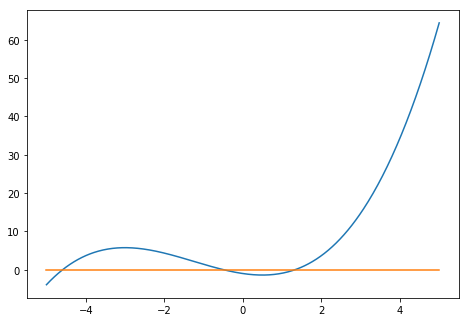

(<matplotlib.axes._axes.Axes at 0x2c29a4ea7f0>,
 <matplotlib.figure.Figure at 0x2c29a5d42e8>)

In [47]:
plot_f(f)

In [52]:
f(4.999990609041445)

64.41632859270987